In [166]:
import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'SSE4_2'
import warnings
warnings.filterwarnings("ignore", message="Intel MKL WARNING*")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
from scipy import stats
import ta
import numba
from scipy.fft import fft
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer

In [167]:
# Constants
returnInterval = 12  # 1 hr
rolling_window = 24 * 7 * returnInterval  # 2 weeks
forecast_period = 24 * returnInterval  # 1 day

# Load and prepare BTC data
btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by="time")
btc_df["return"] = btc_df["close"].diff(returnInterval)  # Calculate returns
btc_df = btc_df.dropna()  # Drop NaN values
btc_df.reset_index(drop=True, inplace=True)
# print(btc_df)
# train_time = pd.to_datetime("09/01/24")

if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by="time")
        x_df["return"] = x_df["close"].diff(returnInterval)  # Calculate returns
        x_df = x_df.dropna()  # Drop NaN values

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            continue
        
        # Initialize lists to store results
        mn_returns = []
        mn_closes = []

        # Loop through the dataset in weekly increments
        for i in range(rolling_window, len(btc_df) - forecast_period, forecast_period):
            # Define training window for beta calculation
            X_train = btc_df["return"].iloc[i-rolling_window:i].values.reshape(-1, 1)
            y_train = x_df["return"].iloc[i-rolling_window:i].values
            
            # Fit linear regression model to calculate beta
            model = LinearRegression().fit(X_train, y_train)

            # Print the beta value (slope)
            # print(f"Day starting at index {i}: Beta calculated: {model.coef_[0]}")

            # Normalize returns for the next week using the calculated beta
            next_week_index = range(i, i + forecast_period)
            X_next_week = btc_df["return"].iloc[next_week_index].values.reshape(-1, 1)
            X_next_week_close = btc_df["close"].iloc[next_week_index].values.reshape(-1, 1)

            mn_return = x_df["return"].iloc[next_week_index] - model.coef_[0] * X_next_week.flatten()
            mn_close = x_df["close"].iloc[next_week_index] - model.coef_[0] * X_next_week_close.flatten()
            mn_returns.extend(mn_return)
            mn_closes.extend(mn_close)

        # Create DataFrame for market neutral results
        MN_x = pd.DataFrame({
            "time": x_df["time"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "close": x_df["close"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "mn_close": mn_closes,
            "mn_return": mn_returns,
            "volume": x_df["volume"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "turnover": x_df["turnover"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
        })

        MN_x.reset_index(drop=True, inplace=True)
        print(filename)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

CHRUSDT.pq
SLPUSDT.pq
GFTUSDT.pq
ALPHAUSDT.pq
MYROUSDT.pq
RONUSDT.pq
SAFEUSDT.pq
ETCPERP.pq
ORBSUSDT.pq
XVSUSDT.pq
MASKUSDT.pq
ZKFUSDT.pq
ENAUSDT.pq
COSUSDT.pq
TNSRUSDT.pq
SNTUSDT.pq
XVGUSDT.pq
SNXUSDT.pq
PENGUSDT.pq
FTMUSDT.pq
VANRYUSDT.pq
XMRUSDT.pq
NEARUSDT.pq
BANDUSDT.pq
ARPAUSDT.pq
ASTRUSDT.pq
WIFUSDT.pq
SILLYUSDT.pq
AEVOUSDT.pq
AKROUSDT.pq
FLRUSDT.pq
DASHUSDT.pq
CYBERUSDT.pq
ORDIPERP.pq
AXLUSDT.pq
OMGUSDT.pq
OPPERP.pq
SSVUSDT.pq
BOMEUSDT.pq
VTHOUSDT.pq
BBUSDT.pq
COREUSDT.pq
POPCATUSDT.pq
ALTUSDT.pq
CELOUSDT.pq
NTRNUSDT.pq
MERLUSDT.pq
ETH-28MAR25.pq
STRKUSDT.pq
LTCUSDT.pq
CVXUSDT.pq
KASUSDT.pq
C98USDT.pq
PHBUSDT.pq
VELOUSDT.pq
LTOUSDT.pq
AMBUSDT.pq
ARUSDT.pq
ETHWUSDT.pq
APTUSDT.pq
CKBUSDT.pq
MNTUSDT.pq
ETHFIUSDT.pq
CAKEUSDT.pq
ATOMUSDT.pq
IDUSDT.pq
IOTXUSDT.pq
OGUSDT.pq
SXPUSDT.pq
HOOKUSDT.pq
GRTUSDT.pq
SOLUSDT.pq
MONUSDT.pq
MAGICUSDT.pq
BTC-27DEC24.pq
PENDLEUSDT.pq
FLOWUSDT.pq
MYRIAUSDT.pq
PORTALUSDT.pq
SUSHIUSDT.pq
ICXUSDT.pq
WUSDT.pq
ZBCNUSDT.pq
1000LUNCUSDT.pq
GTCUSDT.pq
ZILUS

In [169]:
def analyze_lags(selected_coins, lag_periods, data_path='market_neutral/'):
    # Function to load data and prepare it
    def load_and_prepare_data(coin):
        df = pd.read_parquet(os.path.join(data_path, coin))
        df['mn_return'] = df['mn_return'].astype(float)  # Ensure return is float
        return df[['time', 'mn_return']]

    # Function to calculate lagged returns
    def calculate_lags(df, lags):
        for lag in lags:
            df[f'lag_return_{lag}h'] = df['mn_return'].shift(lag)
        return df.dropna()  # Drop NaN values after shifting

    # Store results in a dictionary
    results = {}

    # Load data for all coins in the market_neutral folder only once
    all_coins_data = {}
    for file in os.listdir(data_path):
        if file.endswith('.pq'):
            coin_name = file
            all_coins_data[coin_name] = load_and_prepare_data(coin_name)

    for coin in selected_coins:
        all_coins_data = {}
        for file in os.listdir(data_path):
            if file.endswith('.pq'):
                coin_name = file
                all_coins_data[coin_name] = load_and_prepare_data(coin_name)
        current_df = all_coins_data[coin]
        print(coin)
        # Prepare to store t-stats for regressions
        t_stats = []
        
        # Loop through all other coins (not selected ones)
        for other_coin, other_df in all_coins_data.items():
            if other_coin != coin:
                # Calculate lags for the other cryptocurrency
                other_df_lagged = calculate_lags(other_df, lag_periods)
                
                # Truncate current_df to match lengths after lagging
                min_length = min(len(current_df), len(other_df_lagged))
                current_df_truncated = current_df.iloc[-min_length:].reset_index(drop=True)
                other_df_truncated = other_df_lagged.iloc[-min_length:].reset_index(drop=True)
                
                # Merge dataframes on time index
                merged_df = current_df_truncated.merge(
                    other_df_truncated,
                    on='time',
                    suffixes=('', '_other')
                )
                
                # Test each lag separately
                for lag in lag_periods:
                    X = merged_df[[f'lag_return_{lag}h']].dropna()
                    y = merged_df['mn_return'].iloc[X.index].dropna()
                    
                    if len(X) > 0 and len(y) > 0:
                        # Perform Linear Regression
                        model = LinearRegression()
                        model.fit(X, y)
                        
                        # Calculate t-statistics for coefficients
                        residuals = y - model.predict(X)
                        s_squared = np.sum(residuals**2) / (len(y) - X.shape[1])
                        std_errs = np.sqrt(s_squared * np.linalg.inv(np.dot(X.T, X)).diagonal())
                        
                        t_stat_values = model.coef_ / std_errs

                        # Calculate correlation coefficient
                        correlation_matrix = np.corrcoef(X.values.flatten(), y)
                        correlation_value = correlation_matrix[0, 1]  # Extract the correlation value

                        # Store the t-statistic with coin name, lag value, and correlation value
                        for t_stat in t_stat_values:
                            t_stats.append((other_coin, t_stat, lag, correlation_value))
        
        # Sort by absolute value of t-statistics and get top 10
        top_t_stats = sorted(t_stats, key=lambda x: abs(x[1]), reverse=True)[:10]
        
        results[coin] = top_t_stats

    return results

# Example usage:
selected_coins_list = [
    "MN_SLPUSDT.pq", "MN_ALPHAUSDT.pq", "MN_ORBSUSDT.pq", "MN_MASKUSDT.pq", "MN_PENDLEUSDT.pq", "MN_API3USDT.pq",
    "MN_ACHUSDT.pq", "MN_REEFUSDT.pq", "MN_C98USDT.pq"
]

lag_periods_list = [12, 72, 144, 288]  # Example lag periods (1 hours, 24 hours, etc.)

# Call the function and get results
results_dict = analyze_lags(selected_coins_list, lag_periods_list)

# Display results
for coin, stat in results_dict.items():
    print(f"{coin}: {stat}")

MN_SLPUSDT.pq
MN_ALPHAUSDT.pq
MN_ORBSUSDT.pq
MN_MASKUSDT.pq
MN_PENDLEUSDT.pq
MN_API3USDT.pq
MN_ACHUSDT.pq
MN_REEFUSDT.pq
MN_C98USDT.pq
MN_SLPUSDT.pq: [('MN_1000BTTUSDT.pq', np.float64(17.55831632894687), 72, np.float64(0.09687374860981648)), ('MN_CTCUSDT.pq', np.float64(12.921902061868892), 288, np.float64(0.07144221129286041)), ('MN_GODSUSDT.pq', np.float64(12.221424663105942), 288, np.float64(0.06759237228674166)), ('MN_FTNUSDT.pq', np.float64(-11.830763611747708), 288, np.float64(-0.06544015681166612)), ('MN_COTIUSDT.pq', np.float64(10.418098405928367), 72, np.float64(0.057651662031614814)), ('MN_SPECUSDT.pq', np.float64(9.73241301321158), 72, np.float64(0.0538716678769972)), ('MN_TLMUSDT.pq', np.float64(9.695747829281972), 12, np.float64(0.05366847524012117)), ('MN_GODSUSDT.pq', np.float64(-9.223945316773925), 144, np.float64(-0.05106431052219493)), ('MN_SWEATUSDT.pq', np.float64(9.1375658918065), 144, np.float64(0.05058725775595683)), ('MN_FOXYUSDT.pq', np.float64(8.98217863695334

In [172]:
df_dict = {}
for key in results_dict.keys():
    mn_df = pd.read_parquet(f'market_neutral/{key}')
    mn_df.set_index("time", inplace=True)

    # Loop through each entry in results_dict for MN_ALPHAUSDT
    for coin_name, t_stat, lag, correlation in results_dict[key]:
        # Load the other coin's DataFrame
        other_df = pd.read_parquet(f"market_neutral/{coin_name}")
        other_df.set_index("time", inplace=True)
        
        # Lag the 'mn_close' column by the specified number of rows
        other_df[f'{coin_name}_lagged_return_{lag}'] = other_df['mn_return'].shift(lag)
        
        # Merge the lagged values back into mn_df
        mn_df = mn_df.merge(other_df[[f'{coin_name}_lagged_return_{lag}']], left_index=True, right_index=True, how='left')
    
    mn_df["y"] = (mn_df["mn_close"].shift(-returnInterval)-mn_df["mn_close"])/np.abs(mn_df["mn_close"])
    mn_df = mn_df.dropna()
    print(len(mn_df))
    # Display the updated mn_df with lagged values
    df_dict[key] = mn_df.copy()
    # mn_silly.drop(columns=["turnover"], inplace=True)

# print(df_dict)

32532
32532
32532
32532
32532
32532
32532
32532
32532


In [173]:
def generate_features(df):
    # Ensure the dataframe is sorted by time
    
    # The mn_return column already contains 1-hour returns
    # df['log_return'] = np.log(df['mn_close']/df["mn_close"].shift(1))  # Adding 1 to handle negative returns
    print("done")
    # Custom moving averages and related features
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).mean()
        df[f'ema_{window}h'] = df['mn_return'].ewm(span=window*returnInterval, adjust=False).mean()
        df[f'return_ma_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).mean()
        df[f'return_std_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).std()
        df[f'z_score_{window}h'] = (df['mn_close'] - df[f'sma_{window}h']) / df['mn_close'].rolling(window=window*returnInterval).std()
    print("done")
    # Price momentum
    for lag in [1, 5, 10, 20]:
        df[f'momentum_{lag}h'] = df['mn_close'].pct_change(lag*returnInterval)
    print("done")
    # Return autocorrelation

    @numba.jit(nopython=True)
    def autocorr(x, lag):
        return np.correlate(x[lag:] - x[lag:].mean(), x[:-lag] - x[:-lag].mean())[0] / (np.std(x[lag:]) * np.std(x[:-lag]) * len(x[lag:]))

    def rolling_autocorr(series, window, lag):
        return series.rolling(window=window).apply(lambda x: autocorr(x, lag), raw=True, engine='numba')

    # In your generate_features function:
    for lag in [1, 5, 10, 20]:
        df[f'return_autocorr_{lag}h'] = rolling_autocorr(df['mn_return'], lag*returnInterval*2, lag*returnInterval)
    print("done")
    # Volatility measures
    df['volatility_4h'] = df['mn_return'].rolling(window=returnInterval*4).std()
    df['volatility_1d'] = df['mn_return'].rolling(window=returnInterval*24).std()
    df['volatility_1w'] = df['mn_return'].rolling(window=returnInterval*24*7).std()
    print("done")
    # Range-based features
    df['daily_range'] = df['mn_close'].rolling(window=returnInterval*24).max() - df['mn_close'].rolling(window=returnInterval*24).min()
    df['price_range_percentile'] = (df['mn_close'] - df['mn_close'].rolling(window=returnInterval*24).min()) / df['daily_range']
    print("done")
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['mn_close'], window=returnInterval*24).rsi()
    print("done")
    # MACD
    macd = ta.trend.MACD(df['mn_close'], window_slow=26*returnInterval, window_fast=12*returnInterval, window_sign=9*returnInterval)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    print("done")
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['mn_close'], window=20*60)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_pct'] = (df['mn_close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    print("done")
    # Transformed features
    df['rank_price'] = df['mn_close'].rank(pct=True)
    df['ts_rank_price_1d'] = df['mn_close'].rolling(window=returnInterval).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))
    df['price_change_rate'] = df['mn_close'].pct_change(returnInterval)  # 1-hour change rate
    print("done")
    # Volume-based features
    df['volume_ma_1d'] = df['volume'].rolling(window=returnInterval*24).mean()
    df['volume_ma_1w'] = df['volume'].rolling(window=returnInterval*24*7).mean()
    df['relative_volume'] = df['volume'] / df['volume_ma_1d']
    print("done")
    # Turnover-based features
    df['turnover_ma_1d'] = df['turnover'].rolling(window=returnInterval*24).mean()
    df['turnover_ma_1w'] = df['turnover'].rolling(window=returnInterval*24*7).mean()
    df['relative_turnover'] = df['turnover'] / df['turnover_ma_1d']
    print("done")
    # Fourier transforms for cyclical patterns
    # def fourier_transform(x, num_components=3):
    #     if len(x) == 0:
    #         return np.nan
    #     f = fft(x)
    #     f_abs = np.abs(f)
    #     indices = np.argsort(f_abs)[::-1][:num_components]
    #     return np.sum(f_abs[indices])  # Return the sum of the magnitudes of the top components

    # # In your generate_features function:
    # df['fourier_7d'] = df['mn_close'].rolling(window=returnInterval*24*7).apply(fourier_transform, raw=True)
    # print("done")
    # # Fractal dimension
    # def hurst_exponent(x):
    #     lags = range(2 * returnInterval, 100 * returnInterval, returnInterval)
    #     tau = [np.sqrt(np.std(np.subtract(x[lag:], x[:-lag]))) for lag in lags]
    #     poly = np.polyfit(np.log(lags), np.log(tau), 1)
    #     return poly[0] * 2.0
    
    # df['hurst_exponent'] = df['mn_close'].rolling(window=returnInterval*24).apply(hurst_exponent)
    
    # Cross-sectional neutralization (assuming you have multiple assets)
    # This would typically be done across assets, but as an example:
    # df['cs_neutral_price'] = df['mn_close'] - df['mn_close'].rolling(window=1440).mean()
    df = df.dropna()
    return df

for key in df_dict.keys():
    print(key)
    df_dict[key] = generate_features(df_dict[key])
    print(len(df_dict[key]))

MN_SLPUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_ALPHAUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_ORBSUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_MASKUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_PENDLEUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_API3USDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_ACHUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_REEFUSDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517
MN_C98USDT.pq
done
done
done
done
done
done
done
done
done
done
done
done
30517


In [174]:
for key in df_dict.keys():
    print(df_dict[key])

                        close  mn_close  mn_return     volume     turnover  \
time                                                                         
2024-06-16 00:55:00  0.003594 -0.002547  -0.000020  2946570.0  10604.87430   
2024-06-16 01:00:00  0.003592 -0.002399  -0.000027  5331720.0  19143.09869   
2024-06-16 01:05:00  0.003595 -0.002395  -0.000034   606960.0   2182.70822   
2024-06-16 01:10:00  0.003593 -0.002396  -0.000045   364720.0   1310.28551   
2024-06-16 01:15:00  0.003599 -0.002392  -0.000067  1169390.0   4206.85277   
...                       ...       ...        ...        ...          ...   
2024-09-29 23:35:00  0.002770 -0.000731   0.000010   572620.0   1584.53212   
2024-09-29 23:40:00  0.002765 -0.000733   0.000007   334520.0    926.63123   
2024-09-29 23:45:00  0.002760 -0.000739  -0.000005   329680.0    911.40445   
2024-09-29 23:50:00  0.002765 -0.000732   0.000012   250290.0    691.96146   
2024-09-29 23:55:00  0.002767 -0.000735   0.000009   634350.0   

In [179]:
train_time = pd.to_datetime("09/01/24")
predictions_lgbm = {}
predictions_linear = {}
times = []
timePrev = []
for key, mn_df in df_dict.items():
    X = mn_df
    print(key)
    X = X.drop(columns="mn_close")
    X_train = X[X.index < train_time]
    y_train = X_train["y"]
    X_train = X_train.drop(columns=["y"])
    X_test = X[X.index >= train_time]
    y_test = X_test["y"]
    X_test = X_test.drop(columns=["y"])
    print(len(X_test))

    # params = {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 1.0, "verbose":-1}
    params = {"verbose":-1}
    lgbm_model = LGBMRegressor(**params)
    lgbm_model.fit(X_train, y_train)
    y_pred_train = lgbm_model.predict(X_train)
    y_pred_test = lgbm_model.predict(X_test)
    # timePrev = time.copy()
    times.append(X_test.index)
    # print(time == timePrev)
    predictions_lgbm[key] = y_pred_test
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_train_linear = linear_model.predict(X_train)
    y_pred_test_linear = linear_model.predict(X_test)
    predictions_linear[key] = y_pred_test_linear

    # print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
    print(f"LGBM Train R2: {r2_score(y_pred_train, y_train)}")
    # print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")
    print(f"LGBM Test R2: {r2_score(y_pred_test, y_test)}")

    print(f"Linear Train R2: {r2_score(y_pred_train_linear, y_train)}")
    # print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
    # print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")
    print(f"Linear Test R2: {r2_score(y_pred_test_linear, y_test)}")
    
print(times)

MN_SLPUSDT.pq
8352
LGBM Train R2: 0.3475175995422979
LGBM Test R2: -1.0238335316143692
Linear Train R2: -120.03316389164628
Linear Test R2: -59.69221176201725
MN_ALPHAUSDT.pq
8352
LGBM Train R2: 0.051657697466391816
LGBM Test R2: -3.2531303789151123
Linear Train R2: -292.58908301933013
Linear Test R2: -2084.870740449385
MN_ORBSUSDT.pq
8352
LGBM Train R2: -0.6010083596931328
LGBM Test R2: -0.4163648175779979
Linear Train R2: -113.19628906230034
Linear Test R2: -0.2317928936639415
MN_MASKUSDT.pq
8352
LGBM Train R2: 0.4508809603060677
LGBM Test R2: -42.16441836473895
Linear Train R2: -160.56368472750856
Linear Test R2: -1993.619045387418
MN_PENDLEUSDT.pq
8352
LGBM Train R2: 0.8255550139859913
LGBM Test R2: -1.7045434329651763
Linear Train R2: -24.499244194488206
Linear Test R2: -9.287930627620817
MN_API3USDT.pq
8352
LGBM Train R2: 0.816150689115968
LGBM Test R2: -1.6831967408440063
Linear Train R2: -58.63549641715642
Linear Test R2: -0.21855924619220635
MN_ACHUSDT.pq
8352
LGBM Train R2: -

LGBM Preds:
8352
Total Return: 850.6574877414636
Sharpe Ratio: 0.15249403902872977
Max Drawdown: 276.2678502346263


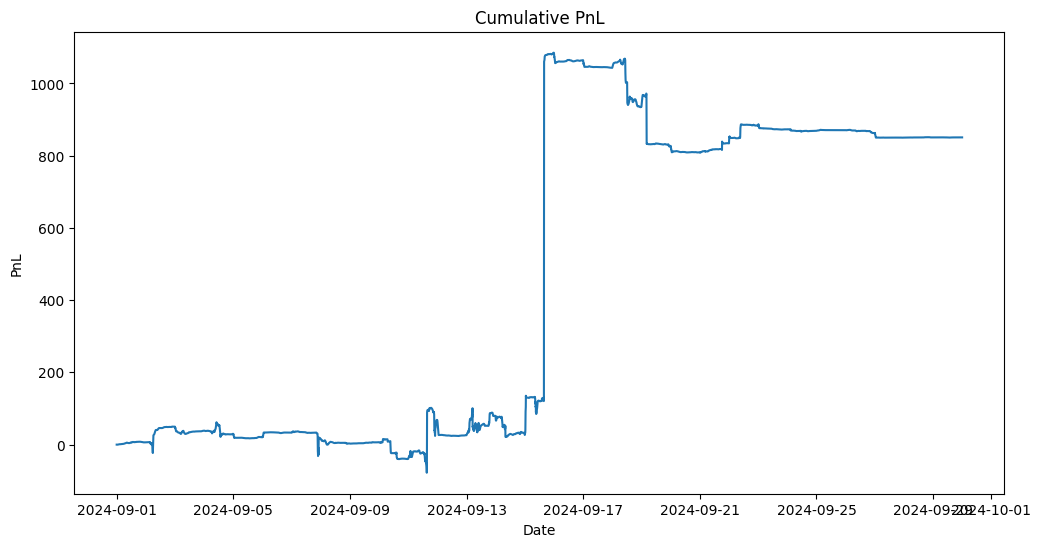

Linear Preds:
8352
Total Return: 193.52360573253873
Sharpe Ratio: 0.1768887496595845
Max Drawdown: 155.32940696134992


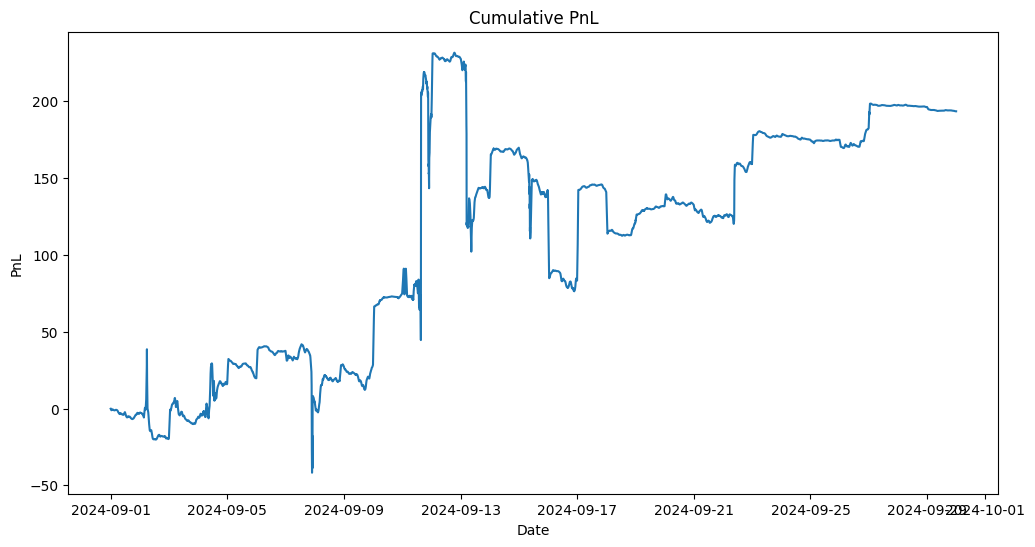

In [186]:
def backtest_multi_coin_strategy(predictions_dict, data_path='market_neutral/', train_time=None, returnInterval=12, spread=0.00175):
    # Load data for all coins
    coin_data = {}
    for coin in predictions_dict.keys():
        df = pd.read_parquet(f"{data_path}/{coin}")
        df.set_index('time', inplace=True)
        df = df.sort_index()
        coin_data[coin] = df

    # Calculate returns distribution for each coin before train_time
    returns_std = {}
    for coin, df in coin_data.items():
        pre_train_returns = df[df.index < train_time]['mn_return']
        returns_std[coin] = np.std(pre_train_returns)

    # Prepare combined DataFrame for backtesting
    combined_df = pd.DataFrame()
    for coin, df in coin_data.items():
        combined_df[f'{coin}_close'] = df['mn_close']
        combined_df[f'{coin}_next_change'] = df['mn_close'].shift(-returnInterval) - df['mn_close']

    # Filter data after train_time
    combined_df = combined_df.loc[times[0]]
    print(len(combined_df))
    # Add predictions to combined_df
    for coin, preds in predictions_dict.items():
        combined_df[f'{coin}_pred'] = preds

    # Calculate signals and positions
    for coin in predictions_dict.keys():
        combined_df[f'{coin}_signal'] = combined_df[f'{coin}_pred'] / returns_std[coin]
        combined_df[f'{coin}_position'] = combined_df[f'{coin}_signal']

    # Normalize positions to ensure sum of absolute values doesn't exceed 1
    position_columns = [f'{coin}_position' for coin in predictions_dict.keys()]
    combined_df['total_position'] = combined_df[position_columns].abs().sum(axis=1)
    for coin in predictions_dict.keys():
        combined_df[f'{coin}_position'] = combined_df[f'{coin}_position'] / combined_df['total_position']

    # Calculate PnL for each coin
    total_pnl = 0
    for coin in predictions_dict.keys():
        close_price = combined_df[f'{coin}_close']
        position = combined_df[f'{coin}_position']
        next_change = combined_df[f'{coin}_next_change']
        
        # Calculate trade amount in dollars
        trade_amount = position * 1  # Assuming $1 total investment
        
        # Calculate number of coins traded
        num_coins = trade_amount / close_price
        
        # Calculate PnL
        coin_pnl = num_coins * next_change - spread * np.abs(num_coins) * close_price
        combined_df[f'{coin}_pnl'] = coin_pnl
        total_pnl += coin_pnl

    # Calculate cumulative PnL
    combined_df['total_pnl'] = total_pnl
    combined_df['cumulative_pnl'] = combined_df['total_pnl'].cumsum()

    # Calculate additional metrics
    total_return = combined_df['cumulative_pnl'].iloc[-1]
    sharpe_ratio = np.sqrt(252) * combined_df['total_pnl'].mean() / combined_df['total_pnl'].std()
    max_drawdown = (combined_df['cumulative_pnl'].cummax() - combined_df['cumulative_pnl']).max()

    return combined_df, total_return, sharpe_ratio, max_drawdown

# Example usage:
train_time = pd.to_datetime("09/01/24")

print("LGBM Preds:")
results_df, total_return, sharpe_ratio, max_drawdown = backtest_multi_coin_strategy(predictions_lgbm, train_time=train_time)


print(f"Total Return: {total_return}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['cumulative_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()


print("Linear Preds:")
results_df, total_return, sharpe_ratio, max_drawdown = backtest_multi_coin_strategy(predictions_linear, train_time=train_time)
print(f"Total Return: {total_return}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['cumulative_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()
